In [1]:
"""
Main program that models the lake (thermal structure + solids concentration). 
TO FILL!
"""

"comments"

import os
import numpy as np
# from lake_functions import *
# from lake_cases import *
import datetime as dtt
import matplotlib.pyplot as plt

In [2]:
#%% ###########################################################################
def surfheat(Tw,Ta,Wsp,RH,P,C):
    """
    Compute the surface heat flux Hsurf [W/m^2] at a given time (Hsurf>0 for cooling).
     
    INPUTS:
        Tw: lake temperature [°C]
        Ta: air temperature [°C]
        Wsp: wind speed [m/s]
        RH: relative humidity [%]
        P: atmospheric pressure [Pa]
        C: couldiness [-]
        
    OUTPUTS:
        Hsurf: dsurface heat flux [W/m^2]
    """
    
    # 0. Parameters
    AL=0.03 # [-]
    Ew=0.972 # [-], emissivity of water
    sigma=5.67E-8 # [W/m^2/K^4], Boltzmann constant 
    Cpa=1005 # [J/kg/K], specific heat of air
    Lv=2470E3 # [J/kg]
    a=1.09
    P=P/100 # [hPa]
    def e_sat(T): # T: numerical array with temperature values
        return 611.2*np.exp(17.62*T/(243.12+T)) # [Pa] with T in [°C]  
    
    # 1. Compute the heat fluxes 
         
    ea=e_sat(Ta)*RH/100  # [Pa]
         
    # a. Sensible heat
    f=4.8+1.98*Wsp+0.28*(Tw-Ta)  # [W/m^2/mbar]
    Hsens=-1*(-Cpa*P/(0.622*Lv)*f*(Tw-Ta))  # [W/m^2], P in [hPa]
     
    # b. Latent heat
    Hlat=-1*(-f*(e_sat(Tw)-ea)/100)  # [W/m^2]
     
    # c. Longwave radiation
    Ea=a*(1+0.17*C**2)*1.24*(ea/100/(Ta+273.15))**(1/7)  # [-]
    HlwIN=-1*((1-AL)*sigma*Ea*(Ta+273.15)**4)  # [W/m^2]
    HlwOUT=(Ew*sigma*(Tw+273.15)**4) 
     
    # d. Total
    Hsurf=HlwOUT+HlwIN+Hsens+Hlat 
    return Hsurf
        
#%% ###########################################################################
def seasonal_therm(h,dt,B,N2):
    """
    Calculate the thermocline depth hnew [m] at the next time step (t+dt) from 
    the current depth (time t).
    
    INPUTS : 
        h: depth of the termocline at time t [m]
        dt: time step [s]
        B: buoyancy flux at time t [W/kg]
        N2: buoyancy frequency at time t [s^(-2)]
    
    
    OUTPUTS:
        hnew: depth of the termocline at time t+dt [m]
        
    """
    
    # Parameters
    A=0.2  # [-], entrainment coefficient
    
    if N2<=0:
        sys.exit("ERROR: The water column is not stratified")
    
    if B>0:  # Unstable conditions
        for t in np.arange(1,dt/3600+1,1): # Hourly time step
            h=h+3600*(1+2*A)*B/(N2*h) 
        hnew=h
        
    else:  # Stable conditions
       hnew=6
   
    return hnew

###############################################################################
def rho_TCss(T,Css,rho_p=2650):
    """
    Calculate the density from temperature and solids concentration.
    
    INPUTS : 
        T: water temperature [°C]
        Css: solids concentration [mg/L]
        rho_p: density of particles [kg/m^3]
    
    
    OUTPUTS:
        rho_w: water density [kg/m^3]
        
    """
    def rho_T(T):
        return 999.84298 + (65.4891*T-8.56272*T**2+0.059385*T**3)*10**(-3) # [kg/m^3]
    
    rho_w=rho_T(T)+Css*10**(-3)*(1-rho_T(T)/rho_p) # [kg/m^3]
    return rho_w

###############################################################################
def alphaT(T):
    """
    Calculate the thermal expansivity of water.
    
    INPUTS : 
        T: water temperature [°C]
        
    OUTPUTS:
        alphaval: thermal expansivity [K^-1]
        
    """
    alphaval=10**(-6)*(-65.4891+17.12544*T-0.178155*T**2)
    return alphaval

In [3]:
"""
Three cases used by the model: winter (case1), fall turnover (case 2), stratified season (case 3).
For each case, computation of the temperatures, solids concentration and thermocline
depth at the next time step. 

TO FILL!
"""

import numpy as np
import sys
# from lake_functions import alphaT,rho_TCss, seasonal_therm
from statistics import mean

def case1(VAR_LAKE,Twinter=4,hmax=8):
    """
    Winter case: ice-covered lake, no heat fluxes = constant temperatures 
    and concentrations. 
     
    INPUTS:
        VAR_LAKE: dictionary containing
            T_epi, T_hypo: epilimnion and hypolimnion temperatures [°C]
            Css_epi, Css_hypo: epilimnion and hypolimnion solids concentrations [mg/L]
            h_epi: thermocline depth [m]
        Twinter: temperature of maximum density [°C]
        hmax: lake depth [m]
        
    OUTPUTS:
        VAR_LAKE: dictionary containing the same variables than VAR_LAKE but at the next time step
    """

    # -------- CODE --------
    # Temperature
    T_epi1 = Twinter
    T_hypo1 = Twinter
    # solid concentrations
    Css_epi1 = VAR_LAKE["Css_epi"]
    Css_hypo1 = VAR_LAKE["Css_hypo"]

    h_epi1 = hmax
    
    VAR_LAKE_NEW1={"T_epi":T_epi1,"T_hypo":T_hypo1,"Css_epi":Css_epi1,"Css_hypo":Css_hypo1,"h_epi":h_epi1}
    print('case1')

    return VAR_LAKE_NEW1

In [4]:

def case2(VAR_LAKE,Hsurf,Hsw0,tyear,iceon,Vs,C_FFT,hmax=8,g=9.81,Cpw=4200,Twinter=4,A0=7.8*10**6):
    """
    Fall turnover case: one box with heat fluxes.
     
    INPUTS:
        VAR_LAKE: dictionary containing
            T_epi, T_hypo: epilimnion and hypolimnion temperatures [°C]
            Css_epi, Css_hypo: epilimnion and hypolimnion solids concentrations [mg/L]
            h_epi: thermocline depth [m]
        Hsurf: surface heat flux [W/m^2]
        Hsw0: surface radiation flux [W/m^2]
        tyear: time as DOY
        iceon: iceon date as DOY
        Vs: settling velocity [m/s]
        C_FFT: solids concentration in the FFT [g/m^3]
        hmax: lake depth [m]
        g: gravitational acceleration [m/s^2]
        Cpw: heat capacity of water [J.kg^(-1).K^(-1)]
        Twinter: temperature of maximum density [°C]
        A0: lake surface area [m^2]
        
        
    OUTPUTS:
        VAR_LAKE: dictionary containing the same variables than VAR_LAKE but at the next time step
        iceon: iceon date as DOY (modified only if ice formation after initial iceon date)
    """
    # -------- CODE --------
    # ----Initial setup----
    h_epi2 = VAR_LAKE["h_epi"]  # Thermocline depth
    T2 = VAR_LAKE["T_epi"]  # Temperature, constant
    T_hypo = VAR_LAKE["T_hypo"] # Hypolimnion temperature for stable condition
    Css2 = VAR_LAKE["Css_epi"] # Initial solid concentration constants
    Cssh_2 = VAR_LAKE["Css_hypo"]
    
    # --Redistribution--
    rho_epi = rho_TCss(T2,Css2)  # [kg/m^3]
    rho_hypo = rho_epi
    alpha2 = alphaT(T2)
    
    kd = 0.325 + 66 * Css2 / 1000  # mg/L
    Hsw_epi2 = Hsw0 * (1 - np.exp(-kd * h_epi2))
    B = alpha2*g*(Hsurf + Hsw_epi2) / (rho_epi * Cpw)

    # --stability and concentration calculate--
    if B > 0: # unstable, fully mixed, new epi. depth is constant
        hepi_new = hmax
        Qnet2 = -(Hsurf + Hsw0)
        dT2 = (Qnet2*24*60*60/(rho_epi*h_epi2*Cpw))
        Tepi_new = T2 + dT2
        Thypo_new = Tepi_new
        
        if Tepi_new <= 4: #Ice formation case
            if tyear > 200:
                iceon = tyear
            else:
                print("Warning, Ice in Summer!")
            Tepi_new = Twinter
            Thypo_new = Twinter
            Csse_new = Css2
            Cssh_new = Cssh_2
        else: # no ice
            # calculate velocities
            rho_30 = rho_TCss(T2, 30*10**5)
            N_fft2 = g*(rho_30-rho_epi)/(0.5*np.mean((rho_epi,rho_30))) 
            Vr = (1+2*0.2)*B/(N_fft2*hmax)
            # water mass
            m_w0 = rho_epi*A0*hmax 
            # new settling velocity
            Vconv=0.6*(B*h_epi2)**(1/3)
            Vs_epi=Vs-Vconv    # [m/s]
            if Vs_epi<0:
                Vs_epi=0
            # new concentration
            m_sed = -Css2*Vs_epi*A0*24*60*60
            m_red = C_FFT*Vr*A0*24*60*60
            m_initial = Css2*h_epi2*A0
            m_new = m_initial+m_sed+m_red
            Csse_new = m_new/(A0*hmax)
           
            if Csse_new < 0:
                print("Warning, Solid Concentration Error!")
                Csse_new = 0
            elif Vr < 0:
                print("Warning, Resettling Velocity Error!")
            Cssh_new = Csse_new
                
    else: # stable
        T_avg = T2 + Hsurf *24*3600/(Cpw*rho_epi*h_epi2)
        T_surf = 2*T_avg - T_hypo
        # density of 2 layers
        rho1 = rho_TCss(T_surf,Css2)
        rho2 = rho_TCss(T_hypo,Cssh_2)
        rho_avg = (rho1+rho2)/2
        # N^2
        N_2 = g*(rho2 - rho1)/ rho_avg / h_epi2 # be careful with the density
        # new depth of thermocline
        hepi_new = seasonal_therm(h_epi2,3600*24,B,N_2)
        # ---Identify: stratified---
        if hepi_new > (hmax - 0.1): # stratified ignored
            hepi_new = hmax
            Tepi_new = T_avg
            Thypo_new = T_avg
        else:
            T_therm = T_surf - (hepi_new/hmax)*(T_surf - T_hypo)
            Tepi_new = 0.5 * (T_therm + T_surf)
            Thypo_new = 0.5 * (T_hypo + T_therm)
            
        Csse_new = Css2
        Cssh_new = Cssh_2

    VAR_LAKE_NEW2={"T_epi":Tepi_new,"T_hypo":Thypo_new,"Css_epi":Csse_new,"Css_hypo":Cssh_new,"h_epi":hepi_new}
    print('case2')
    return VAR_LAKE_NEW2, iceon

In [12]:
def case3(VAR_LAKE,Hsurf,Hsw0,tyear,iceon,Vs,ustar,hmax=8,g=9.81,Cpw=4200,Twinter=4,A0=7.8*10**6,Dth=1.4E-7):
    """
    spring-summer, 2 boxes.
     
    INPUTS:
        VAR_LAKE: dictionary containing
            T_epi, T_hypo: epilimnion and hypolimnion temperatures [°C]
            Css_epi, Css_hypo: epilimnion and hypolimnion solids concentrations [mg/L]
            h_epi: thermocline depth [m]
        Hsurf: surface heat flux [W/m^2]
        Hsw0: surface radiation flux [W/m^2]
        tyear: time as DOY
        iceon: iceon date as DOY
        Vs: settling velocity [m/s]
        ustar: friction velocity [m/s]
        hmax: lake depth [m]
        g: gravitational acceleration [m/s^2]
        Cpw: heat capacity of water [J.kg^(-1).K^(-1)]
        Twinter: temperature of maximum density [°C]
        A0: lake surface area [m^2]
        Dth: thermal molecular diffusivity [m^2/s]
        
  
    OUTPUTS:
        VAR_LAKE: dictionary containing the same variables than VAR_LAKE but at the next time step
        iceon: iceon date as DOY (modified only if ice formation after initial iceon date)
    """
        # --- import necessary equations from other script ---
    # from lake_model import Css_epi
    # from lake_functions import rho_TCss, seasonal_therm

    # ---- initial setup ---
    T_epi = VAR_LAKE["T_epi"]
    T_hypo = VAR_LAKE["T_hypo"]
    Css_epi = VAR_LAKE["Css_epi"]
    Css_hypo = VAR_LAKE["Css_hypo"]
    h_epi = VAR_LAKE["h_epi"]

    # --- constants ---
    Cp = Cpw
    dt = 86400 # time step [s]

    # --- compute densities ---
    rho_epi = rho_TCss(T_epi, Css_epi) # water density [kg/m^3]
    rho_hypo = rho_TCss(T_hypo, Css_hypo)
    rho_avg = 0.5 * (rho_epi + rho_hypo)

    # --- compute N^2---
    N2 = g * (rho_hypo - rho_epi) / (0.5 * hmax)
    
    # --- Additional information: shortwave-radiative flux: beer-lambert law ---
    c0 = 0.325
    c1 = 66  # m^-1 * (g/L)^-1
    kd = c0 + c1 * (Css_epi / 1000)  # Css in g/L
    Hsw_epi = Hsw0 * (1 - np.exp(-kd * h_epi))

    # --- compute buoyancy flux ---
    alpha = alphaT(T_epi)
    B_flux = alpha * g * (Hsurf + Hsw_epi) / (rho_epi * Cp)
    if B_flux<0:
        B_flux=0
    

    # --- Additional information: vertical diffusive heat flux ---
    dTdz = (T_epi - T_hypo) / (0.5 * hmax)

    epsilon=0.56/(0.4*h_epi)*ustar**3+0.77*B_flux  # [W/kg]
    Kz = 0.2*epsilon/N2  # [m^2/s]
    H_diff = -rho_avg * Cp * (Dth + Kz) * dTdz

    # --- net heat fluxes ---
    H_epi_net = -Hsurf - Hsw_epi + H_diff
    H_hypo_net = - Hsw0 + Hsw_epi - H_diff

    # --- thermocline depth ---
    h_epi_new = seasonal_therm(h_epi, dt, B_flux, N2)
    dh = h_epi_new - h_epi  # change in the thermocline depth
    dhdt = abs(dh / dt) # absolute value because only looks at velocity, not direction

    # --- convective velocity (only if B > 0) ---
    v_therm = dh / dt # velocity of thermocline change
    if B_flux > 0:
        v_conv = 0.6 * (B_flux * h_epi)**(1/3) # convective velocity
    else:
        v_conv = 0

    # --- settling velocity in epilimnion ---
    vs_epi = max(0, Vs - v_conv - abs(v_therm))
    vs_hypo = Vs
    print("vs_epi",vs_epi,"vs_hypo",Vs)

    # --- mass flux from sedimentation ---
    F_sed_epi = dt * vs_epi * A0 * Css_epi # sedimentation from epi to hypo [mg]
    F_sed_hypo = dt * vs_hypo * A0 * Css_hypo

    # --- mass added due to thermocline motion ---
    if dh > 0: # thermocline deepens → hypo water moves to epi
        F_red = Css_hypo * A0 * dh
    else: # thermocline shallows → epi water moves to hypo
        F_red = Css_epi * A0 * abs(dh)

    # --- mass balances ---
    Mss_epi = Css_epi * h_epi * A0 - F_sed_epi + F_red
    Mss_hypo = Css_hypo * (hmax - h_epi) * A0 + F_sed_epi - F_red - F_sed_hypo

    # --- Updated concentrations ---
    Css_epi_new = max(0, Mss_epi / (h_epi_new * A0))
    Css_hypo_new = max(0, Mss_hypo / ((hmax - h_epi_new) * A0))

    # --- updated temperatures ---
    T_epi_new = T_epi + H_epi_net * dt / (rho_epi * Cp * h_epi_new)
    T_hypo_new = T_hypo + H_hypo_net * dt / (rho_hypo * Cp * (hmax - h_epi_new))

    # --- What if after calculation we get an unstable or mixed situation? ---
    if rho_TCss(T_epi_new, Css_epi_new) >= rho_TCss(T_hypo_new, Css_hypo_new) or h_epi_new > (hmax - 0.1): # completely mixed: one bow model
        # switch to 1-box model
        h_epi_new=hmax 
        T_epi_new=T_epi+(-Hsurf-Hsw_epi)*24*3600/(Cp*rho_epi*h_epi_new) 
        T_hypo_new=T_epi_new 
        
        Css_epi_new=(Css_epi*h_epi+Css_hypo*(hmax-h_epi))/hmax 
        Css_hypo_new=Css_epi_new 

    
    # --- What if we have some ice signal? ---
    if T_epi_new <= 4:
        if tyear > 200: # re-feezing scenario
        # switch to ice case
            iceon=tyear
        else:
            print('Warning: there is ice in warm conditions!')
    

    VAR_LAKE_NEW = {"T_epi": T_epi_new, "T_hypo": T_hypo_new, "Css_epi": Css_epi_new, "Css_hypo": Css_hypo_new, "h_epi": h_epi_new}
    print('case3')
    return VAR_LAKE_NEW,iceon,F_red,F_sed_epi,F_sed_hypo

In [13]:
# PARAMETERS
#Time
nyears=2
tyear=np.tile(np.arange(1,366,1),[1,nyears]) # DOY
tyear=tyear[0];
t=np.arange(1,365*nyears+1,1) # Time in days from the first day

# Meteorological data:
meteodata_NASA =np.genfromtxt("Meteo_data_NASA.txt", usecols=tuple(np.arange(3,9,1)),skip_header=1,dtype=float)
meteodata_NASA=np.tile(meteodata_NASA,[nyears,1]) 
Ta=meteodata_NASA[:,4]  # [°C]
RH=meteodata_NASA[:,2]  # [#]
Wsp=meteodata_NASA[:,5]  # [m/s]
R=meteodata_NASA[:,1]*10**6/(24*3600)  # [W/m^2]
P=meteodata_NASA[:,3]*1000  # [Pa]

# Atmospheric variables:
rho_air=1.2  # [kg/m^3], air density
CD=0.001  # [-], drag coefficient

#Basin:
hmax=8; # [m], lake depth

# Heat fluxes:
Twinter=4
Adiff=0.066  # [-], albedo of diffuse shortwave radiation
Adir=0.1  # [-], albedo of direct shortwave radiation (approximate value for 50°N)
C=0.5  # Cloudiness
Fdir=(1-C)/((1-C)+0.5*C) 
Fdiff=0.5*C/((1-C)+0.5*C) 
Hsw0=-R*(Fdir*(1-Adir)+Fdiff*(1-Adiff))  # [W/m^2], shortwave radiation (<0) passing through the lake surface

# Gravity
g=9.81 # [m.s^(-2)]

# Water and particles properties:
Dp=1.6*10**(-6)  # [m]
rho_p=2650 # [kg/m^3]
nu=1E-6  # [m^2/s]
Vs=g*(rho_p-1000)/1000*Dp**2/(18*nu)  # [m/s], settling velocity
f_fft=10  # [%], solids content in the FFT
C_FFT=f_fft*10**4  # [g/m^3], solids concentration in the FFT


In [14]:
# THERMOCLINE

iceoff=(dtt.datetime(2015,4,26)-dtt.datetime(2015,1,1)).days  # iceoff DOY (based on observations)
iceon=max(t)   # initial value for the iceon DOY, it will be calculated by the simulation
h_epi=np.zeros(np.shape(t)); h_epi[0]=hmax 


In [15]:
# INITIALIZATION

 # Temperature:
T_epi=np.zeros(np.shape(t)); T_epi[0]=Twinter   # [°C]
T_hypo=np.zeros(np.shape(t)); T_hypo[0]=Twinter   # [°C]

 # Solids concentration:
Css_epi=np.zeros(np.shape(t)); Css_epi[0]=100   # [mg/L]
Css_hypo=np.zeros(np.shape(t)); Css_hypo[0]=100   # [mg/L]

#initialize m_* variables:
m_add=np.zeros(np.shape(t));
m_sedi=np.zeros(np.shape(t));
m_sedi_hypo=np.zeros(np.shape(t));

In [16]:
# ITERATIONS
for k in np.arange(len(t)-2): 
 
    VAR_LAKE={"T_epi":T_epi[k],"T_hypo":T_hypo[k],"Css_epi":Css_epi[k],"Css_hypo":Css_hypo[k],"h_epi":h_epi[k]}
    
    if tyear[k]<iceoff or tyear[k]>iceon:  # Case 1: ice
        VAR_LAKE=case1(VAR_LAKE)
    elif h_epi[k]==hmax: # Case 2: fall turnover.
        Hsurf=surfheat(T_epi[k],Ta[k],Wsp[k],RH[k],P[k],C)
        
        VAR_LAKE,iceon=case2(VAR_LAKE,Hsurf,Hsw0[k],tyear[k],iceon,Vs,C_FFT) 
    else: # Case 3: stratified period. 
        Hsurf=surfheat(T_epi[k],Ta[k],Wsp[k],RH[k],P[k],C)
        rho_epi=rho_TCss(T_epi[k],Css_epi[k]);
        ustar=np.sqrt(rho_air*CD*Wsp[k]**2/rho_epi); 
        VAR_LAKE,iceon,m_add_new,m_sedi_new,m_sedi_hypo_new=case3(VAR_LAKE,Hsurf,Hsw0[k],tyear[k],iceon,Vs,ustar)
        m_add[k+1]=m_add_new
        m_sedi[k+1]=m_sedi_new
        m_sedi_hypo[k+1]=m_sedi_hypo_new   
    T_epi[k+1]=VAR_LAKE["T_epi"]
    T_hypo[k+1]=VAR_LAKE["T_hypo"]
    Css_epi[k+1]=VAR_LAKE["Css_epi"]
    Css_hypo[k+1]=VAR_LAKE["Css_hypo"]
    h_epi[k+1]=VAR_LAKE["h_epi"]
    
    lake_list = []
    lake_list.append(VAR_LAKE.copy())
    print(k, lake_list)
    print(iceon)

case1
0 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
1 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
2 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
3 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
4 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
5 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
6 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
7 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
8 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
9 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
10 [{'T_epi': 4, 'T_hypo': 4, 'Css_epi': 100.0, 'Css_hypo': 100.0, 'h_epi': 8}]
730
case1
11 [{'T_epi': 

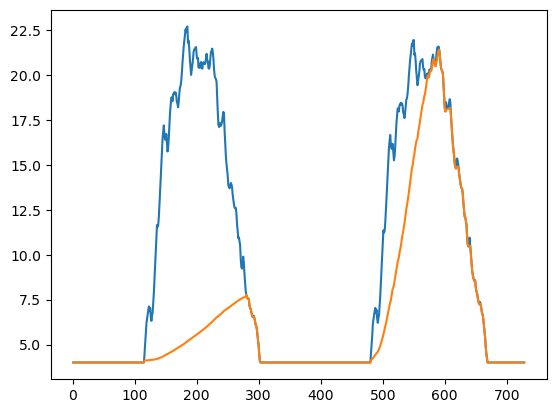

In [10]:
plt.plot(t[:-2],T_epi[:-2])
plt.plot(t[:-2],T_hypo[:-2])

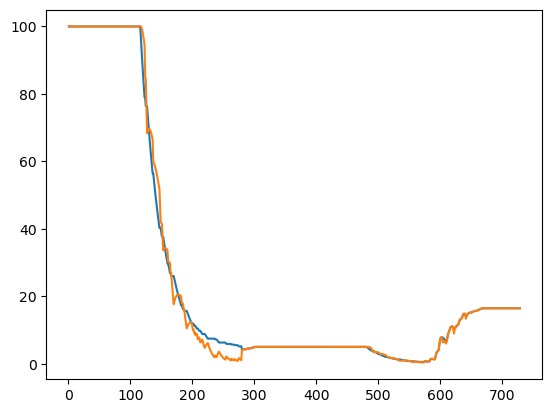

In [11]:
plt.plot(t[:-2],Css_epi[:-2])
plt.plot(t[:-2],Css_hypo[:-2])

NameError: name 'timestep' is not defined

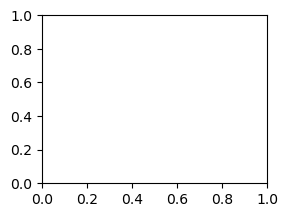

In [69]:
# PLOTS
# use for sample
#---Temperature---
Tepi_plt = [d["T_epi"] for d in lake_list] # use lake_list structure just for an example
plt.subplot(2, 2, 1)
# How to add a time step label to the dictionary?
plt.plot(timestep,Tepi_plt,color='orange', label='T_epi (°C)')
plt.plot() # same for hypo-temp.
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.title('Epilmnion and Hypolimnion Temperature')
plt.legend()